First of all we are going to load our CSVs.
The goal is try to predict the Iberdrola stock price, so I've loaded data from values I thing are related with the Iberdrola stock price, like the eur_usd, eur_gbp, oil_price, ibex35 and other competitors

Imports

In [8]:
import numpy as np
from matplotlib import pyplot
from datetime import date as dt
from datetime import timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.regularizers import l2

Now import all the csvs

In [9]:
#groups = ["iberdrola", "ibex", "oil", "gas_natural", "endesa", "usd", "gbp"]
#groups = ["iberdrola", "ibex", "oil", "usd", "gbp"]
groups = ["iberdrola", "ibex", "oil"]
data = {}

for x in groups:
    data[x] = np.genfromtxt('csvs/csv/%s.csv'%x, delimiter=',', skip_header=1)

In [10]:
#day,month,year,opening_value,close_value,min_value,max_value,volume
data["iberdrola"][0]

array([1.500000e+01, 6.000000e+00, 2.018000e+03, 6.666000e+00,
       6.712000e+00, 6.612000e+00, 6.742000e+00, 3.869992e+07])

Order the input putting the dates in format year-month-day

In [11]:
for group in groups:
    data[group][:,[0, 2]] = data[group][:,[2, 0]]
    
data["iberdrola"][0]

array([2.018000e+03, 6.000000e+00, 1.500000e+01, 6.666000e+00,
       6.712000e+00, 6.612000e+00, 6.742000e+00, 3.869992e+07])

See the graphics of the data we imported from the csv from year 2005

7.501
15945.7
1616.0


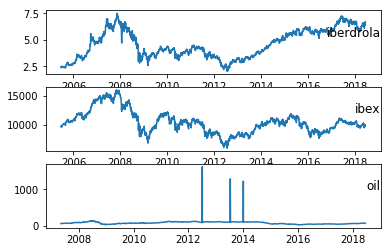

In [12]:
# plot the close value for each date
def to_time(time_array):
    return dt(day = int(round(time_array[2])), month = int(round(time_array[1])), year = int(round(time_array[0])))

pyplot.figure()
i = 1
for group in groups:
    group_data = data[group]
    print(np.max(group_data[:,4]))
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(list(map(to_time, group_data[:,0:3])), group_data[:,4])
    pyplot.title(group, y=0.5, loc='right')
    i += 1
pyplot.show()

We see that we have some strange data in the oil and gbp plots (possible cause bad data retrieved from external servers), so remove this outliers to have a nice plot and trustable values

In [13]:
def remove_outliers(group_data, outlierConstant):
    closed_values = group_data[:,4]
    upper_quartile = np.percentile(closed_values, 75)
    lower_quartile = np.percentile(closed_values, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartile_set = (lower_quartile - IQR, upper_quartile + IQR)
    mask = np.logical_and(group_data[:,4] >= quartile_set[0],group_data[:,4] <= quartile_set[1])
    result_list = group_data[mask,:]
    return result_list

clean_dataset = {}
for group in groups:
    group_data = data[group]
    without_outliers = remove_outliers(group_data, 3.5)
    total_removed = len(group_data) - len(without_outliers)
    print("Found %d outliers for group: %s" % (total_removed, group))
    clean_dataset[group] = without_outliers

Found 0 outliers for group: iberdrola
Found 0 outliers for group: ibex
Found 3 outliers for group: oil


Now our dataset (clean_dataset) is clean and we can use it as input in our LTSM:

7.501
15945.7
145.15


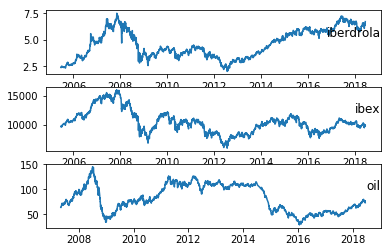

In [14]:
pyplot.figure()
i = 1
for group in groups:
    group_data = clean_dataset[group]
    print(np.max(group_data[:,4]))
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(list(map(to_time, group_data[:,0:3])), group_data[:,4])
    pyplot.title(group, y=0.5, loc='right')
    i += 1
pyplot.show()

Now we are going to unify all our data in the same row. For that, we are going to build a csv with the following columns:

day, month, year, [opening, close, min, max, volume]+

 (but volume will not be available in currencies or oil)
 
 But first get the common dates between all our datasets, to build this big csv

In [15]:
all_dates = []
group_selected = None
min_length_found = -1
dates_converted_by_group = {}

#TODO vectorize
#Get all dates in our dataset
for group in groups:
    dates_groups = clean_dataset[group][:,0:3]
    converted_dates = []
    for date in dates_groups:
        parsed_date = to_time(date)
        converted_dates.append(parsed_date)
        if parsed_date not in all_dates:
            all_dates.append(parsed_date)
    
    dates_converted_by_group[group] = converted_dates
            
print("Found %d different dates" % len(all_dates))
print("Example: %s" % all_dates[100])    
        

Found 3355 different dates
Example: 2018-01-23


Now get only the shared dates between all the datasets

In [16]:
#TODO: Vectorized
filtered_dates = []

for date in all_dates:
    in_all_groups = True
    for group in groups:
        in_all_groups = in_all_groups and date in dates_converted_by_group[group]
    if in_all_groups:
        filtered_dates.append(date)
        
print("Found %d common dates" % len(filtered_dates))
print("Example: %s" % filtered_dates[100])   

Found 2669 common dates
Example: 2018-01-17


Now, create a dictionary by time with the data from all the groups

In [17]:
#Initialize dictionary
final_dict = {}

for date in filtered_dates:
    final_dict[date]={}


for group in groups:
    group_data = clean_dataset[group]
    for row in group_data:
        date = to_time(row)
        if date in filtered_dates:
            data_array = []
            #if group in ["oil", "gbp", "usd"]:
            data_array =  [row[4]] #Put just close_value
            #else:
            #    data_array = row[3:]
            final_dict[date][group] = data_array
        
print("Length of dataset: %d" % len(final_dict))
print("Example : %s" % final_dict[filtered_dates[100]])
    

Length of dataset: 2669
Example : {'ibex': [10474.6], 'oil': [69.0], 'iberdrola': [6.706]}


Now convert it to a final numpy matrix:

In [18]:
final_array = np.zeros((len(final_dict), 3+len(groups)*1))

i = 0

for date in sorted(final_dict.keys()):
    
    data_array = [date.year, date.month, date.day]
    
    for group in groups:
        row = final_dict[date][group]
        data_array = np.concatenate((data_array, row))

    final_array[i, :] = data_array
    i = i + 1
    
print("Length of dataset: %d" % len(final_array))
print("Example : %s" % final_array[0])
#day,month,year,[(opening_value,close_value,min_value,max_value,volume)+

Length of dataset: 2669
Example : [2.00700e+03 5.00000e+00 8.00000e+00 5.62300e+00 1.45567e+04 6.35600e+01]


In [19]:
def print_with_format(row):
    headers = ["year","month","day"]
    for group in groups:
        for x in ["opening_value","close_value","min_value","max_value","volume"]:
            if group in ["oil","usd","gbp"]:
                if x is not "volume":
                    headers.append("%s_%s" % (group,x))
            else:
                headers.append("%s_%s" % (group,x))
            
    print("Row:")
    for header,data in zip(headers,row):
        print("%s:\t%s" % (header, data))
        
print_with_format(final_array[0])

Row:
year:	2007.0
month:	5.0
day:	8.0
iberdrola_opening_value:	5.623
iberdrola_close_value:	14556.7
iberdrola_min_value:	63.56


As you see our array is ordered by date:

In [20]:
print("First three rows: %s %s %s" % (to_time(final_array[0]), to_time(final_array[1]), to_time(final_array[2])) )
print("Last three rows: %s %s %s" % (to_time(final_array[2495]), to_time(final_array[2496]), to_time(final_array[2497])) )

First three rows: 2007-05-08 2007-05-09 2007-05-10
Last three rows: 2017-09-29 2017-10-02 2017-10-03


# Neural network

Now we are going to split our dataset in training set, dev set, and test set to check that all is working at should.

Because we want to predict what will happen knowing the 100 days before, we are going to package in 100 rows packages all the rows, and setting the next day as expected prediction

So we have to:
- Create packages with 100 days
- Generate an expected output for each of this packages (will be the first row in the next package)
- Normalize all the inputs
- Build the neural network

Normalize the final_array

In [21]:
mean = final_array.mean(axis = 0)
std = final_array.std(axis = 0)
normalized = (final_array - mean) / std

Generate the 100-day packages:

In [22]:
package_size = 100
m = final_array.shape[0]
expected_m = m - package_size
number_features = normalized.shape[1]

X = np.zeros((expected_m, package_size, number_features))
Y = np.zeros((expected_m, number_features - 3))

for i in range(0,expected_m):
    package = normalized[ i : i + package_size ]
    #Remove dates because I think is predicting bad the problem 
    expected_output = normalized[ i + package_size][3:]
    X[i] = package
    Y[i] = expected_output

print("X shape: %s - %s - %s" % X.shape)
print("Y shape: %s - %s" % Y.shape)
print("First package: %s" % X[0])
print("Last package: %s" % X[expected_m - 1])

print("First expected output %s" % Y[0])
print("Last expected output %s" % Y[expected_m -1])

X shape: 2569 - 100 - 6
Y shape: 2569 - 3
First package: [[-1.64447557 -0.43592758 -0.88243766  0.69159546  2.34411262 -0.70075565]
 [-1.64447557 -0.43592758 -0.76778907  0.6705526   2.37192596 -0.70678396]
 [-1.64447557 -0.43592758 -0.65314047  0.73368118  2.35398187 -0.65102212]
 [-1.64447557 -0.43592758 -0.53849187  0.81860414  2.43889965 -0.6378352 ]
 [-1.64447557 -0.43592758 -0.19454608  0.87121129  2.41235295 -0.61673612]
 [-1.64447557 -0.43592758 -0.07989749  0.90277558  2.4852904  -0.56775613]
 [-1.64447557 -0.43592758  0.03475111  1.04030569  2.5352172  -0.57566828]
 [-1.64447557 -0.43592758  0.14939971  1.16731437  2.56128891 -0.53196306]
 [-1.64447557 -0.43592758  0.2640483   1.13575008  2.6141712  -0.48411338]
 [-1.64447557 -0.43592758  0.60799409  1.16205365  2.60736301 -0.47733153]
 [-1.64447557 -0.43592758  0.72264269  1.19887866  2.61549062 -0.45962338]
 [-1.64447557 -0.43592758  0.83729129  1.25749805  2.69623904 -0.45434861]
 [-1.64447557 -0.43592758  0.95193988  1.21

Shuffle the packages and create training_set (75%) and test_set (25%)

In [23]:
#https://play.pixelblaster.ro/blog/2017/01/20/how-to-shuffle-two-arrays-to-the-same-order/
s = np.arange(X.shape[0])
np.random.shuffle(s)

shuffle_X = X[s]
shuffle_Y = Y[s]

test_set_size = int(shuffle_X.shape[0]*0.25)
print("Estimated test_set_size: %d" % test_set_size)

test_set_X = shuffle_X[0:test_set_size]
test_set_Y = shuffle_Y[0:test_set_size]
training_set_X = shuffle_X[test_set_size:]
training_set_Y = shuffle_Y[test_set_size:]

print("Training set shape: %s - %s - %s" % training_set_X.shape)
print("Test set shape: %s - %s - %s" % test_set_X.shape)


Estimated test_set_size: 642
Training set shape: 1927 - 100 - 6
Test set shape: 642 - 100 - 6


Create the LSTM model:

In [26]:
dropout = 0.1
batch_size = training_set_X.shape[0]

opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rms = RMSprop(lr=0.008)

model = Sequential()
model.add(LSTM(512, stateful = True, return_sequences=True, batch_input_shape=(batch_size, package_size, number_features), dropout=dropout))
model.add(BatchNormalization())
model.add(LSTM(512, dropout=dropout))
model.add(BatchNormalization())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Dense(8))
model.add(BatchNormalization())
model.add(Dense(number_features - 3))

#Add loss function
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

#Compile the model
history = model.fit(training_set_X, training_set_Y, epochs=100, batch_size=batch_size, verbose=2)


Epoch 1/100
 - 64s - loss: 2.7683 - acc: 0.4551
Epoch 2/100
 - 62s - loss: 0.7368 - acc: 0.7125
Epoch 3/100
 - 61s - loss: 0.5224 - acc: 0.7582
Epoch 4/100
 - 61s - loss: 0.3628 - acc: 0.8578
Epoch 5/100
 - 61s - loss: 0.2046 - acc: 0.8770
Epoch 6/100
 - 62s - loss: 0.1620 - acc: 0.9024
Epoch 7/100
 - 61s - loss: 0.1275 - acc: 0.9097
Epoch 8/100
 - 61s - loss: 0.1266 - acc: 0.9253
Epoch 9/100
 - 61s - loss: 0.1096 - acc: 0.8801
Epoch 10/100
 - 61s - loss: 0.1022 - acc: 0.8879
Epoch 11/100
 - 61s - loss: 0.0883 - acc: 0.9102
Epoch 12/100
 - 61s - loss: 0.0886 - acc: 0.9071
Epoch 13/100
 - 61s - loss: 0.0741 - acc: 0.9081
Epoch 14/100
 - 61s - loss: 0.0690 - acc: 0.9118
Epoch 15/100
 - 61s - loss: 0.0652 - acc: 0.9113
Epoch 16/100
 - 62s - loss: 0.0616 - acc: 0.9336
Epoch 17/100
 - 61s - loss: 0.0580 - acc: 0.9242
Epoch 18/100
 - 61s - loss: 0.0573 - acc: 0.9299
Epoch 19/100
 - 61s - loss: 0.0524 - acc: 0.9299
Epoch 20/100
 - 61s - loss: 0.0494 - acc: 0.9211
Epoch 21/100
 - 61s - loss: 0

Evaluate the model

In [28]:
print("Training set performance")
print(model.evaluate(training_set_X, training_set_Y, batch_size = batch_size))
print("Test set performance")
print(model.evaluate(test_set_X, test_set_Y, batch_size = batch_size))

Training set performance
1927/1927 [==============================] - 24s 12ms/step
[0.01959346979856491, 0.9626362323760986]
Test set performance


ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 642 samples

Plot the graphic of the neural network:

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
pyplot.plot(history.history['acc'])
pyplot.show()
# summarize history for loss
pyplot.plot(history.history['loss'])
pyplot.show()

Now we are going to compare the predicted with the real values in the 100 last dates:

In [ ]:
#Get 101 rows (it's hundred packages but not really :P)
last_hundred_packages = X[X.shape[0] - 101:]
last_package = last_hundred_packages[last_hundred_packages.shape[0] - 1]
last_package_row = last_package[last_package.shape[0] - 1]

print("last_hundred_packages shape: %s " % str(last_hundred_packages.shape))
print("last_package shape: %s" % str(last_package.shape))
print("last_package_row shape: %s" % str(last_package_row.shape))

print("\nMean in reg: %s" % str(mean))
print("Std in reg: %s" % str(std))

def denormalize(row):
    return row* std + mean


last_date_found = denormalize(last_package_row)

print("\nLast row found: %s" % str(denormalize(last_package_row)))
print("Last date found %s" % to_time(last_date_found))

In [ ]:
predicted = np.zeros((last_hundred_packages.shape[0] - 1, number_features))
print(predicted.shape)

for i in range(last_hundred_packages.shape[0] - 1):
    package = last_hundred_packages[i]
    next_package = last_hundred_packages[i+1]
    y_predicted =  model.predict(np.array([package]))
    date_predicted = next_package[next_package.shape[0] - 1][0:3]
    
    predicted[i] = np.append(date_predicted, y_predicted)
    
    print("Date prediction %s" % to_time(denormalize(next_package[next_package.shape[0] - 1])))
    
    
print("Last predicted row: %s" % str(denormalize(predicted[predicted.shape[0] - 1])))
last_predicted_date = to_time(denormalize(predicted[predicted.shape[0] - 1]))
print("Last predicted date %s" % last_predicted_date)

In [ ]:
#Now plot the predicted vs the last_hundred_dates

last_package_denorm = np.zeros((last_package.shape))
predicted_denorm = np.zeros((predicted.shape))

for i in range(last_package.shape[0]):
    last_package_denorm[i] = denormalize(last_package[i])
    predicted_denorm[i] = denormalize(predicted[i])

pyplot.figure()
print(np.max(last_package_denorm[:,3]))
print(np.max(predicted_denorm[:,3]))

pyplot.plot(list(map(to_time, last_package_denorm[:,0:3])), last_package_denorm[:,3])
pyplot.plot(list(map(to_time, predicted_denorm[:,0:3])), predicted_denorm[:,3])

pyplot.show()


Now generate the prediction for the next 100 days:

In [ ]:
sampling_package = last_package
days_to_predict = 21
future_predictions = np.zeros((days_to_predict, number_features))

def next_day(day): 
    n_day = day + timedelta(days=1)
    while(n_day.weekday() > 4):
        n_day = n_day + timedelta(days=1)
    return n_day
    
next_day_generated = next_day(last_predicted_date)

for i in range(days_to_predict):
    print("\nGenerating for %s" % next_day_generated)
    predicted = model.predict(np.array([sampling_package]))
    
    #Generate the normalized date using an empty row  and changing the date
    
    fake_date_row = np.append([next_day_generated.year, next_day_generated.month, next_day_generated.day], np.zeros(number_features - 3))
    
    date_norm = (fake_date_row - mean)/std
    
    row = np.append(date_norm[0:3], predicted[0])

    future_predictions[i] = row
    
    print("Date generated: %s" % to_time(denormalize(future_predictions[i])))
    print("Inserted denormalized : %s" % str(denormalize(row)))
    
    sampling_package = np.concatenate((sampling_package[1:], np.array([row])))
    
    print("Shape of sampling_package: %s" % str(sampling_package.shape))
    print("First date found %s" % to_time(denormalize(sampling_package[0])))
    print("Last date found %s" % to_time(denormalize(sampling_package[sampling_package.shape[0] - 1])))
    
    next_day_generated = next_day(next_day_generated)
    
    

In [ ]:
#Denormalize and plot
future_predictions_denorm = np.zeros((future_predictions.shape))

for i in range(future_predictions.shape[0]):
    future_predictions_denorm[i] = denormalize(future_predictions[i])
    
pyplot.figure()
print(np.max(future_predictions_denorm[:,3]))

pyplot.plot(list(map(to_time, future_predictions_denorm[:,0:3])), future_predictions_denorm[:,3])

pyplot.show()



In [ ]:
model.save('two_lstm_smooth_stateful.h5')